In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tarfile
import os
from matplotlib import rcParams




warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
carpeta = './datos/'

datos = pd.read_csv(carpeta + 'datos_segundos.csv.gz', index_col=0, compression='gzip')

In [3]:
datos.head()

,dia_habil,hora_laboral,N_jobs_esp,N_jobs_fin
segundostamp,,,,
600,1,1,2,16
601,1,1,0,8
602,1,1,0,11
603,1,1,1,11
604,1,1,5,10


# Analisis de N_jobs_esp

<function matplotlib.pyplot.show(*args, **kw)>

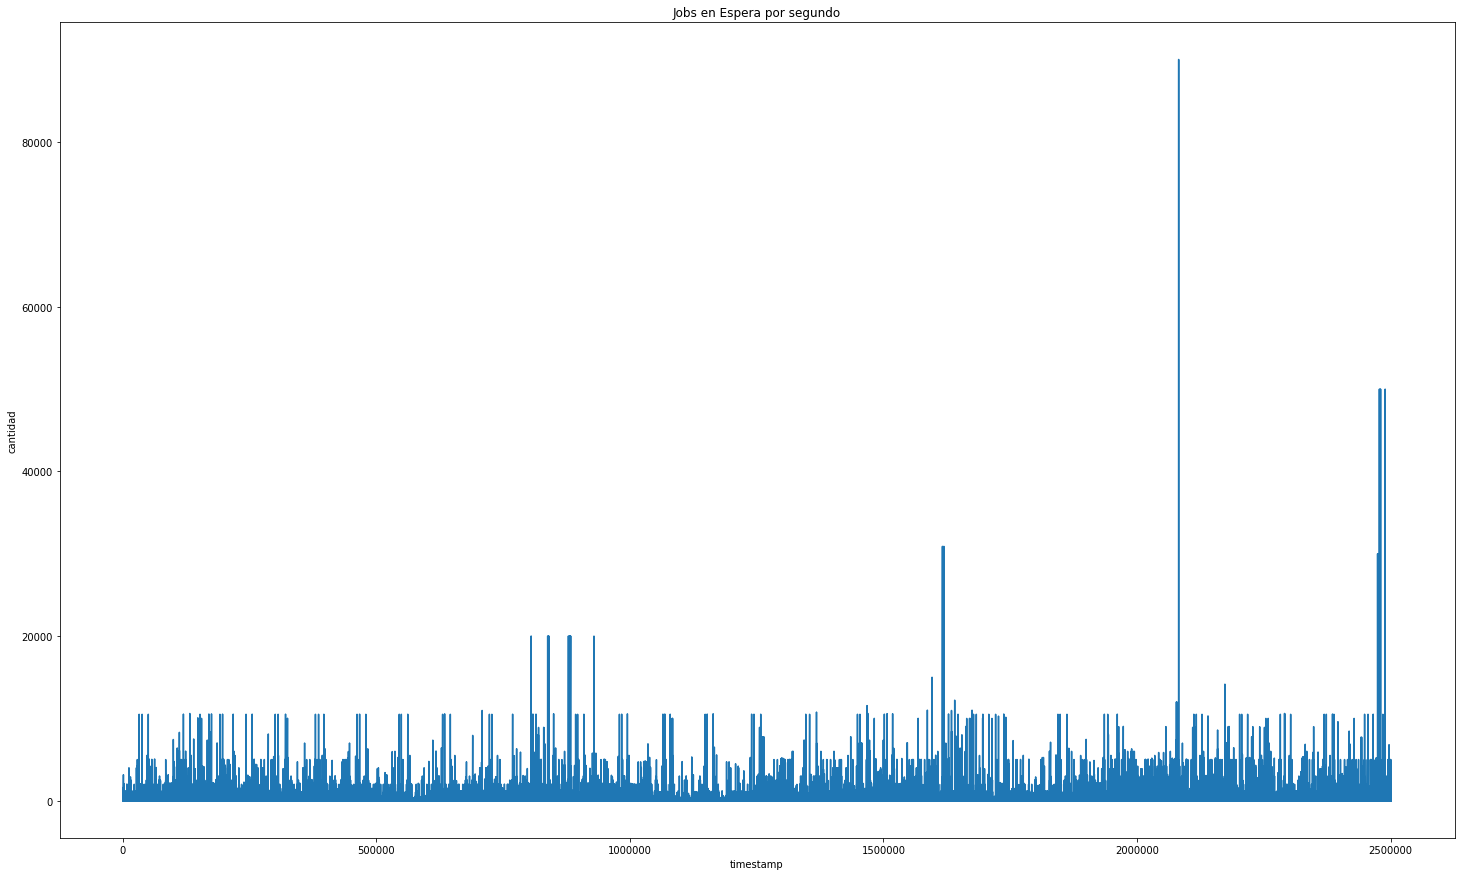

In [4]:
rcParams['figure.figsize'] = 25, 15

x = datos.index
y1 = datos.N_jobs_esp

plt.plot(x, y1)
plt.title('Jobs en Espera por segundo')
plt.ylabel('cantidad')
plt.xlabel('timestamp')
plt.show

In [9]:
import pymc3 as pm
import theano.tensor as tt

n_datos = datos.shape[0]



In [10]:

with pm.Model() as model:
    # alpha para dia habil
    alpha1 = 1.0/datos.loc[datos['dia_habil']==0]['N_jobs_esp'].mean()
    # alpha para dia no habil
    alpha2 = 1.0/datos.loc[datos['dia_habil']==1]['N_jobs_esp'].mean()
    
    # alpha para hora laboral
    alpha3 = 1.0/datos.loc[datos['hora_laboral']==0]['N_jobs_esp'].mean()
    # alpha para hora no laboral
    alpha4 = 1.0/datos.loc[datos['hora_laboral']==1]['N_jobs_esp'].mean()
                                   
    lambda_1 = pm.Exponential("lambda_1", alpha1)
    lambda_2 = pm.Exponential("lambda_2", alpha2)
    lambda_3 = pm.Exponential("lambda_3", alpha3)
    lambda_4 = pm.Exponential("lambda_4", alpha4)
    


In [12]:
datos.reset_index(drop=True, inplace=True)

def lambda_(lambda_1=lambda_1, lambda_2=lambda_2, lambda_3=lambda_3, lambda_4=lambda_4):
    out = np.zeros(n_datos)
    out[datos.loc[datos['dia_habil']==0].index] = lambda_1
    out[datos.loc[datos['dia_habil']==1].index] = lambda_2
    out[datos.loc[datos['hora_laboral']==0].index] = lambda_3
    out[datos.loc[datos['hora_laboral']==1].index] = lambda_4
    return out


In [69]:

out = np.zeros(n_datos)
out[datos.loc[datos['dia_habil']==0].index] = lambda_1
out[datos.loc[datos['dia_habil']==1].index] = lambda_2
out[datos.loc[datos['hora_laboral']==0].index] = lambda_3
out[datos.loc[datos['hora_laboral']==1].index] = lambda_4



ValueError: setting an array element with a sequence.

In [16]:
lambda_1


lambda_1

In [14]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=datos.N_jobs_esp)
    model = pm.Model([observation, lambda_1, lambda_2, lambda_3, lambda_4])

TypeError: float() argument must be a string or a number, not 'function'

In [16]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(500, tune=250,step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 1500/1500 [09:12<00:00,  2.31draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [17]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']



In [ ]:
print(len(lambda_1_samples))

In [ ]:
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_datos, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_datos))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(n_datos)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");